In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
train_ds, test_ds = tfds.load('fashion_mnist', split=['train', 'test'], as_supervised=True)





Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incompletePFQP75/fashion_mnist-train.tfrecord


  0%|          | 0/60000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incompletePFQP75/fashion_mnist-test.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [2]:

def prepare_mnist_data(mnist):

  #flatten the images into vectors
  #mnist = mnist.map(lambda img, target: (tf.reshape(img, (-1,)), target))

  #convert data from uint8 to float32
  mnist = mnist.map(lambda img, target: (tf.cast(img, tf.float32), target))

  #sloppy input normalization, just bringing image values from range [0, 255] to [-1, 1]
  mnist = mnist.map(lambda img, target: ((img/128.)-1., target))

  #create one-hot targets
  mnist = mnist.map(lambda img, target: (img, tf.one_hot(target, depth=10)))

  #cache this progress in memory, as there is no need to redo it; it is deterministic after all
  mnist = mnist.cache()


  #shuffle, batch, prefetch
  mnist = mnist.shuffle(1000)
  mnist = mnist.batch(32)
  mnist = mnist.prefetch(20)

  #return preprocessed dataset
  return mnist





In [3]:
train_dataset = train_ds.apply(prepare_mnist_data)
test_dataset = test_ds.apply(prepare_mnist_data)

print(train_dataset)
print(test_dataset)

<PrefetchDataset shapes: ((None, 28, 28, 1), (None, 10)), types: (tf.float32, tf.float32)>
<PrefetchDataset shapes: ((None, 28, 28, 1), (None, 10)), types: (tf.float32, tf.float32)>


In [4]:
# ref doc : https://developers.google.com/codelabs/tensorflow-4-cnns#2


from tensorflow.keras.layers import Dense

class My_Model(tf.keras.Model):
    
    def __init__(self):
        super(My_Model, self).__init__()
        

        self.convlayer_1 = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1, 1), padding="same",activation=tf.nn.relu, 
                                                  kernel_regularizer = tf.keras.regularizers.l2(l2=0.01))
        self.poolinglayer_1 = tf.keras.layers.MaxPool2D(pool_size=(2,2) ,strides=(1, 1), padding="same")

        self.convlayer_2 = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1, 1), padding="same",activation=tf.nn.relu,
                                                  kernel_regularizer = tf.keras.regularizers.l2(l2=0.01))
        self.poolinglayer_2 = tf.keras.layers.MaxPool2D(pool_size=(2,2) ,strides=(1, 1), padding="same")
        
        
        self.flatten_layer = tf.keras.layers.Flatten()  



        self.dense1 = tf.keras.layers.Dense(128, activation=tf.nn.relu)
        self.dense2 = tf.keras.layers.Dense(64, activation=tf.nn.relu)
        self.out = tf.keras.layers.Dense(10, activation=tf.nn.softmax)

    @tf.function
    def call(self, inputs):
        x = self.convlayer_1(inputs)
        x = self.poolinglayer_1(x)

        x = self.convlayer_2(x)
        x = self.poolinglayer_2(x)

        x=self.flatten_layer(x)

        x = self.dense1(x)
        x = self.dense2(x)
        x = self.out(x)
        return x
    

In [5]:
def train_step(model, input, target, loss_function, optimizer):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape:
    prediction = model(input)
    #print(prediction)
    loss = loss_function(target, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss



In [7]:
def test(model, test_data, loss_function):
  # test over complete test data

  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (input, target) in test_data:
    prediction = model(input)
    #print(prediction.shape)
    sample_test_loss = loss_function(target, prediction)
    sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    sample_test_accuracy = np.mean(sample_test_accuracy)
    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = tf.reduce_mean(test_loss_aggregator)
  test_accuracy = tf.reduce_mean(test_accuracy_aggregator)

  return test_loss, test_accuracy

In [8]:
tf.keras.backend.clear_session()

#For showcasing we only use a subset of the training and test data (generally use all of the available data!)
#train_dataset = train_dataset.take(1000)
#test_dataset = test_dataset.take(100)

### Hyperparameters
num_epochs = 10
learning_rate = 0.001

# Initialize the model.
model = My_Model()
# Initialize the loss: categorical cross entropy. Check out 'tf.keras.losses'.
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
# Initialize the optimizer: SGD with default parameters. Check out 'tf.keras.optimizers'
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Initialize lists for later visualization.
train_losses = []

test_losses = []
test_accuracies = []

#testing once before we begin
test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

#check how model performs on train data once before we begin
train_loss, _ = test(model, train_dataset, cross_entropy_loss)
train_losses.append(train_loss)

# We train for num_epochs epochs.
for epoch in range(num_epochs):
    print(f'Epoch: {str(epoch)} starting with accuracy {test_accuracies[-1]}')

    #training (and checking in with training)
    epoch_loss_agg = []
    for input,target in train_dataset:
        train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
        epoch_loss_agg.append(train_loss)
    
    #track training loss
    train_losses.append(tf.reduce_mean(epoch_loss_agg))

    #testing, so we can track accuracy and test loss
    test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch: 0 starting with accuracy 0.09165335463258786
Epoch: 1 starting with accuracy 0.8945686900958466
Epoch: 2 starting with accuracy 0.9168330670926518
Epoch: 3 starting with accuracy 0.9165335463258786
Epoch: 4 starting with accuracy 0.921026357827476
Epoch: 5 starting with accuracy 0.9216253993610224
Epoch: 6 starting with accuracy 0.919129392971246
Epoch: 7 starting with accuracy 0.9172324281150159
Epoch: 8 starting with accuracy 0.9142372204472844
Epoch: 9 starting with accuracy 0.9215255591054313


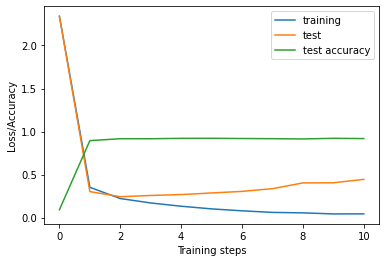

In [9]:
import matplotlib.pyplot as plt

# Visualize accuracy and loss for training and test data.
plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
line3, = plt.plot(test_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Loss/Accuracy")
plt.legend((line1,line2, line3),("training","test", "test accuracy"))
plt.show()